In [135]:
# import the necessary libraries
import pygad
import numpy as np
import matplotlib.pyplot as plt 
import os
import networkx as nx# for plotting graphs
import random
from functions import read_graph_from_txt, directed, write_graph_txt, plot_graph

In [136]:
def initial_population_checkpoint_walk(population_size, num_nodes, checkpoints, edges):
    """
    Generate population using random walks between consecutive checkpoints.
    
    Key constraints:
    - Path must visit checkpoints in order: checkpoints[0], checkpoints[1], ..., checkpoints[n]
    - Nodes CAN be visited multiple times (backtracking allowed)
    - Only actual edges from the graph are used
    - Each segment between checkpoints uses random walk until target checkpoint is reached
    
    Loop Prevention Strategies:
    1. Frequency-based Selection: Tracks node visit counts and biases selection toward less-visited nodes
    2. Adaptive Probability: Increases target-seeking probability as segment grows longer
    
    Example: 
        checkpoints = [1, 2, 3]
        Valid path: [1, 5, 3, 2, 3] 
        - Starts at checkpoint 1
        - Wanders to 5, then 3
        - Reaches checkpoint 2
        - Reaches checkpoint 3
    
    Parameters:
        population_size: number of individuals to generate
        num_nodes: maximum path length (fixed chromosome size)
        checkpoints: list of nodes to visit in order [start, cp1, cp2, ..., goal]
        edges: adjacency list graph_edges[node] = [(neighbor, weight), ...]
    
    Returns:
        numpy array of shape (population_size, num_nodes+1)
    """
    population = []
    
    for _ in range(population_size):
        full_path = []
        
        # Track frequency of each node across entire path to discourage excessive revisits
        node_frequency = {}
        
        # Build path by connecting consecutive checkpoints
        for i in range(len(checkpoints) - 1):
            current_checkpoint = checkpoints[i]  # Where we are now
            target_checkpoint = checkpoints[i + 1]  # Where we need to go
            
            # Start segment: only include current checkpoint for first segment
            # (subsequent segments already have their start from previous segment's end)
            if i == 0:
                segment = [current_checkpoint]
                node_frequency[current_checkpoint] = node_frequency.get(current_checkpoint, 0) + 1
            else:
                segment = []
            
            current_node = current_checkpoint
            
            # Random walk from current checkpoint to target checkpoint
            # Allow some wandering with a random maximum segment length
            # This creates diversity in paths between same checkpoints
            segment_max_length = num_nodes  # Can be adjusted for more/less wandering
            
            for step in range(segment_max_length):
                # Get valid neighbors from the graph (only real edges)
                neighbors = [v for v, w in edges[current_node]]
                
                if not neighbors:
                    # Dead end: force jump to target if no valid edges
                    break
                
                # ADAPTIVE PROBABILITY: Increase target-seeking as segment length grows
                # Start at 60% probability, gradually increase to 90% as we take more steps
                # This prevents infinite wandering and encourages progress
                base_probability = 0.0
                max_probability = 0.4
                # Linear increase based on steps taken
                adaptive_factor = min(step / num_nodes, 1.0)  # Reaches max after num_nodes steps
                target_probability = base_probability + (max_probability - base_probability) * adaptive_factor
                
                # Decision: should we go toward target or explore randomly?
                if target_checkpoint in neighbors and np.random.random() < target_probability:
                    current_node = target_checkpoint
                    segment.append(current_node)
                    node_frequency[current_node] = node_frequency.get(current_node, 0) + 1
                    break  # Reached target checkpoint, move to next segment
                else:
                    # FREQUENCY-BASED SELECTION: Bias selection toward less-visited nodes
                    # Calculate weights inversely proportional to visit frequency
                    # Nodes visited 0 times get highest weight, frequently visited get lower weight
                    neighbor_weights = []
                    for neighbor in neighbors:
                        freq = node_frequency.get(neighbor, 0)
                        # Weight formula: 1 / (frequency + 1)
                        # Never visited (freq=0): weight = 1.0
                        # Visited once (freq=1): weight = 0.5
                        # Visited twice (freq=2): weight = 0.33
                        # This strongly discourages revisiting the same nodes
                        weight = 1.0 / (freq + 1)
                        neighbor_weights.append(weight)
                    
                    # Normalize weights to create probability distribution
                    total_weight = sum(neighbor_weights)
                    probabilities = [w / total_weight for w in neighbor_weights]
                    
                    # Select neighbor based on weighted probabilities
                    # np.random.choice with p parameter performs weighted random selection
                    current_node = np.random.choice(neighbors, p=probabilities)
                    segment.append(current_node)
                    node_frequency[current_node] = node_frequency.get(current_node, 0) + 1
                
                # Check if we accidentally reached the target checkpoint
                if current_node == target_checkpoint:
                    break  # Move to next segment
            
            # Safety: if we exhausted steps without reaching target, force add it
            # This ensures all checkpoints are visited in order
            if current_node != target_checkpoint:
                segment.append(target_checkpoint)
                node_frequency[target_checkpoint] = node_frequency.get(target_checkpoint, 0) + 1
            
            # Append segment to full path
            full_path.extend(segment)
        
        # Pad path to fixed chromosome length with zeros
        # Zeros represent "empty" genes at the end of the path
        while len(full_path) < num_nodes * len(checkpoints) + 1:
            full_path.append(0)
        
        # Ensure exact chromosome size (trim if too long)
        population.append(full_path[:num_nodes * len(checkpoints) + 1])
    
    return np.array(population)

In [137]:
# generate graph
edges = directed(100, 1.0, seed=random.randint(0, 100000))
write_graph_txt(1, 100, 100, edges, 
                f"task2_graph_test_n{100}_p{1.0}.txt")

In [138]:
num_nodes, start, goal, graph_edges = read_graph_from_txt('graphs/task2_graph_test_n100_p1.0.txt')
checkpoints = [start, 2, 3, 5, goal]
pop = initial_population_checkpoint_walk(50, num_nodes, checkpoints, graph_edges)
#print(pop)

In [139]:
def fitness_func(pygad_instance, solution, solution_idx):

    index_checkpoint = 0
    
    total_cost = 0
    solution = [int(gene) for gene in solution if gene != 0]

    # Check if solution is empty or too short (invalid)
    if len(solution) < 2:
        return -100000
    
    # Check if path starts with the start node
    if solution[0] != start:
        return -100000
    
    # Check if path ends with the goal node
    if solution[-1] != goal:
        return -100000

    for i in range(len(solution) - 1):
        if index_checkpoint >= len(checkpoints):
            break

        u = solution[i]
        v = solution[i + 1]

        edge_found = False
        for neighbor, weight in graph_edges[u]:
            if neighbor == v:
                total_cost += weight
                edge_found = True
                break
        
        if not edge_found:
            return -100000

        if checkpoints[index_checkpoint] == u:
            index_checkpoint += 1
    
    # Check if the last node was also counted as a checkpoint
    if index_checkpoint < len(checkpoints) and checkpoints[index_checkpoint] == solution[-1]:
        index_checkpoint += 1
    
    # Verify all checkpoints were visited
    if index_checkpoint != len(checkpoints):
        return -100000

    return -total_cost

In [140]:
def custom_crossover_1(parents, offspring_size, ga_instance):
    # assumes len(checkpoints) >= 3
    offspring = []
    crossover_prob = ga_instance.crossover_probability

    while len(offspring) != offspring_size[0]:
        # pick 2 random parents
        parent1 = parents[np.random.randint(parents.shape[0]), :].copy()
        parent2 = parents[np.random.randint(parents.shape[0]), :].copy()

        parent1_brez_ničel = [gene for gene in parent1 if gene != 0]
        parent2_brez_ničel = [gene for gene in parent2 if gene != 0]

        # in crossover_prob% of cases do crossover
        if(random.random() > crossover_prob):
            offspring.append(parent1)
        # do crossover
        else:
            # pick a random index for the checkpoints that 
            # is not the start or the goal
            checkpoint_idx = random.randint(1, len(checkpoints) -2)


            # offspring path initialized with zeros
            offspring_path = np.zeros(offspring_size[1], dtype=int)

            # walk through checkpoints in parent1 and get to the chosen checkpoint
            idx = 0
            index_child = 0
            for i in range(len(parent1_brez_ničel)): 
                if(parent1_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx):
                        #copy the first part from parent1
                        offspring_path[:i + 1] = parent1_brez_ničel[:i + 1]
                        index_child = i
                        break
                    else:
                        idx += 1

            # walk through parent2 and search for checkpoints 
            # when checkpoint at checkpoint_idx is found copy 
            # everything onwards from it
            idx = 0 
            for i in range(len(parent2_brez_ničel)):
                if(parent2_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx):
                        # copy the remaining part from parent2 (only what fits)
                        remaining_segment = parent2_brez_ničel[i + 1:]
                        available_space = len(offspring_path) - (index_child + 1)
                        copy_length = min(len(remaining_segment), available_space)
                        if copy_length > 0:
                            offspring_path[index_child + 1:index_child + 1 + copy_length] = remaining_segment[:copy_length]
                        break
                    else:
                        idx += 1

            offspring.append(offspring_path)


    return np.array(offspring)




In [141]:
def custom_crossover_2(parents, offspring_size, ga_instance):
    # 2parents 2 splits
    # len(checkpoints) >= 4 
    offspring = []
    crossover_prob = ga_instance.crossover_probability

    while len(offspring) < offspring_size[0]:
        # pick 2 random parents -> ensure they are differnet
        idx_parent_1, idx_parent_2 = random.sample(range(parents.shape[0]), 2)
        parent1 = parents[idx_parent_1, :].copy()
        parent2 = parents[idx_parent_2, :].copy()
        
        # in crossover_prob% of cases do crossover
        if(random.random() > crossover_prob):
            offspring.append(parent1)
            if(len(offspring) == offspring_size[0]): # so that we do not get too many children
                break
            offspring.append(parent2)
        else:

            # make them without zeros which are there only for padding
            parent1_brez_ničel = [gene for gene in parent1 if gene != 0]
            parent2_brez_ničel = [gene for gene in parent2 if gene != 0]

            # pick 2 random indices for the checkpoints that 
            # are not the start or the goal
            possible_indices = range(1, len(checkpoints) - 1)
            checkpoint_idx_1, checkpoint_idx_2 = random.sample(possible_indices, 2) 

            # order checkpoints according to list of checkpoints
            firstNotFound = True
            for ch in checkpoints:
                # if i find the first one
                if(checkpoints[checkpoint_idx_1] == ch): firstNotFound = False
                if(checkpoints[checkpoint_idx_2] == ch and firstNotFound):
                    # swap
                    checkpoint_idx_1, checkpoint_idx_2 = checkpoint_idx_2, checkpoint_idx_1
                    break # we are done: we obtained the infromation of their ordering in checkpoints


            # offspring path initialized with zeros
            offspring_path_1 = np.zeros(offspring_size[1], dtype=int)
            offspring_path_2 = np.zeros(offspring_size[1], dtype=int)


            segment2_for_child2 = []
            # walk through checkpoints in parent1 and get to the chosen checkpoint
            idx = 0
            index_continue = 0
            for i in range(len(parent1_brez_ničel)): 
                if(parent1_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_1):
                        # copy the first segment from parent1 for child1
                        offspring_path_1[:i + 1] = parent1_brez_ničel[:i + 1]
                        index_continue = i + 1 # index in the child from where i append the next part of crossover
                        break
                    if(idx == checkpoint_idx_2):
                        # the second segment from parent1 for child2
                        segment2_for_child2 = parent1[index_continue: index_continue + len(parent1_brez_ničel[index_continue: i + 1])].copy()
                    idx += 1

            # walk through parent2 and search for checkpoints 
            # when checkpoint at checkpoint_idx is found copy 
            # everything onwards from it
            idx = 0 
            index_continue_2 = 0
            for i in range(len(parent2_brez_ničel)):
                if(parent2_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_1):
                        # first segment from parent2 for child2
                        offspring_path_2[: i + 1] = parent2_brez_ničel[: i + 1]
                        # second segment from parent1 for child2 (only what fits)
                        available_space = len(offspring_path_2) - index_continue
                        copy_length = min(len(segment2_for_child2), available_space)
                        if copy_length > 0:
                            offspring_path_2[index_continue: index_continue + copy_length] = segment2_for_child2[:copy_length]
                        index_continue_2 = i + 1 + copy_length
                    elif(idx == checkpoint_idx_2):
                        # second segment from parent2 for child1 (only what fits)
                        segment = parent2_brez_ničel[index_continue_2 : i + 1]
                        available_space_1 = len(offspring_path_1) - index_continue
                        copy_length_1 = min(len(segment), available_space_1)
                        if copy_length_1 > 0:
                            offspring_path_1[index_continue : index_continue + copy_length_1] = segment[:copy_length_1]
                        index_continue = index_continue + copy_length_1
                        # third segment from parent2 for child2 -> child2 FINISHED (only what fits)
                        remaining = parent2_brez_ničel[i + 1:]
                        available_space_2 = len(offspring_path_2) - index_continue_2
                        copy_length_2 = min(len(remaining), available_space_2)
                        if copy_length_2 > 0:
                            offspring_path_2[index_continue_2: index_continue_2 + copy_length_2] = remaining[:copy_length_2]
                        break
                    idx += 1


            # find the checkpoint_idx_2 in parent 1 and copy the last part from parent1
            idx = 0 
            # iterate through parent1 (not parent2!) to find checkpoint_idx_2
            for i in range(len(parent1_brez_ničel)):
                if(parent1_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_2):
                        # the third segment from parent1 for child1-> child1 FINISHED (only what fits)
                        remaining = parent1_brez_ničel[i + 1:]
                        available_space = len(offspring_path_1) - index_continue
                        copy_length = min(len(remaining), available_space)
                        if copy_length > 0:
                            offspring_path_1[index_continue : index_continue + copy_length] = remaining[:copy_length]
                        break
                    
                    idx += 1


            offspring.append(offspring_path_1)
            if(len(offspring) == offspring_size[0]): # so that we do not get too much children
                break
            offspring.append(offspring_path_2)

    return np.array(offspring)

In [142]:
def custom_crossover_3(parents, offspring_size, ga_instance):
    # 3 parents 2 split
    # len(checkpoints) >= 4


    offspring = []

    while len(offspring) < offspring_size[0]:
        
        # pick 3 random parents -> ensure they are different
        idx_parent_1, idx_parent_2, idx_parent_3 = random.sample(range(0, parents.shape[0]), 3)
        parent1 = parents[idx_parent_1, :].copy()
        parent2 = parents[idx_parent_2, :].copy()
        parent3 = parents[idx_parent_3, :].copy()

        # in 20% of cases we just copy the parents
        crossover_prob = ga_instance.crossover_probability
        if(random.random() > crossover_prob):
            offspring.append(parent1)
            if(len(offspring) == offspring_size[0]): # so that we do not get too many children
                break
            offspring.append(parent2)
            # in crossover_prob% of cases do crossover
        else:
            # make them without zeros which are there only for padding
            parent1_brez_ničel = [gene for gene in parent1 if gene != 0]
            parent2_brez_ničel = [gene for gene in parent2 if gene != 0]
            parent3_brez_ničel = [gene for gene in parent3 if gene != 0]


            # pick 2 random indices for the checkpoints that 
            # are not the start or the goal
            possible_indices = range(1, len(checkpoints) - 1)
            checkpoint_idx_1, checkpoint_idx_2 = random.sample(possible_indices, 2) 

            # order checkpoints according to list of checkpoints
            firstNotFound = True
            for ch in checkpoints:
                # if I find the first one
                if(checkpoints[checkpoint_idx_1] == ch): firstNotFound = False
                # if i find the second one before the first one
                if(checkpoints[checkpoint_idx_2] == ch and firstNotFound):
                    # swap
                    checkpoint_idx_1, checkpoint_idx_2 = checkpoint_idx_2, checkpoint_idx_1
                    break # we are done: we obtained the infromation of their ordering in checkpoints

            
            # 2 children from 3 parents
            # offspring path initialized with zeros
            offspring_path_1 = np.zeros(offspring_size[1], dtype=int)
            offspring_path_2 = np.zeros(offspring_size[1], dtype=int)



            # first segment of parent1 for child1
            idx = 0
            index_continue_1 = 0
            for i in range(len(parent1_brez_ničel)): 
                if(parent1_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_1):
                        # copy the first part from parent1 into child1
                        offspring_path_1[:i + 1] = parent1_brez_ničel[:i + 1]
                        index_continue_1 = i + 1 # index in the child from where i append the next part of crossover
                        break
                    
                    idx += 1

            # first segment of parent2 for the second child and the second segment of parent2 for child1
            idx = 0
            index_continue_2 = 0
            for i in range(len(parent2_brez_ničel)):
                if(parent2_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_1): # first segment of parent 2 is for child2
                        # copy the first segment of parent2 in child2
                        offspring_path_2[:i + 1] = parent2_brez_ničel[:i + 1]
                        index_continue_2 = i + 1
                    elif(idx == checkpoint_idx_2): 
                        # second segment of parent2 is for child1 (only what fits)
                        segment = parent2_brez_ničel[index_continue_2: i + 1]
                        available_space = len(offspring_path_1) - index_continue_1
                        copy_length = min(len(segment), available_space)
                        if copy_length > 0:
                            offspring_path_1[index_continue_1: index_continue_1 + copy_length] = segment[:copy_length]
                        index_continue_1 = index_continue_1 + copy_length
                        break

                    idx += 1


            # second segment of parent3 for child2 and third segment of paren3 for child1
            idx = 0
            start_segment = 0
            for i in range(len(parent3_brez_ničel)):
                if(parent3_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_1):
                        # find the start of the segment
                        start_segment = i + 1
                    if(idx == checkpoint_idx_2):
                        # copy the second segment of parent3 into child2 (only what fits)
                        segment = parent3_brez_ničel[start_segment: i + 1]
                        available_space_2 = len(offspring_path_2) - index_continue_2
                        copy_length_2 = min(len(segment), available_space_2)
                        if copy_length_2 > 0:
                            offspring_path_2[index_continue_2: index_continue_2 + copy_length_2] = segment[:copy_length_2]
                        index_continue_2 = index_continue_2 + copy_length_2
                        # copy the third segment of parent3 into child1 -> CHILD1 FINISHED (only what fits)
                        remaining = parent3_brez_ničel[i + 1:]
                        available_space_1 = len(offspring_path_1) - index_continue_1
                        copy_length_1 = min(len(remaining), available_space_1)
                        if copy_length_1 > 0:
                            offspring_path_1[index_continue_1: index_continue_1 + copy_length_1] = remaining[:copy_length_1]
                        break
                    
                    idx += 1
            

            idx = 0
            for i in range(len(parent1_brez_ničel)):
                if(parent1_brez_ničel[i] == checkpoints[idx]):
                    if(idx == checkpoint_idx_2):
                        # copy the last segment of parent1 into child2 -> CHILD2 FINISHED (only what fits)
                        remaining = parent1_brez_ničel[i + 1:]
                        available_space = len(offspring_path_2) - index_continue_2
                        copy_length = min(len(remaining), available_space)
                        if copy_length > 0:
                            offspring_path_2[index_continue_2: index_continue_2 + copy_length] = remaining[:copy_length]
                        break
                    idx += 1

        
            offspring.append(offspring_path_1)
            if(len(offspring) == offspring_size[0]): # so that we do not get too many children
                break
            offspring.append(offspring_path_2)
        
    return np.array(offspring)

In [144]:
def custom_mutation(offspring_population, ga_instance):
    """
    Custom mutation for multi-checkpoint pathfinding.
    Mutates a random segment between two consecutive checkpoints.
    """
    mutated_offspring = []
    mutation_prob = ga_instance.mutation_probability
    
    # Loop through each individual in the population
    for offspring in offspring_population:
        # Apply mutation with some probability (handled by PyGAD's mutation_probability)
        if(np.random.random() < mutation_prob):
            # we mutate the individual
            mutated = mutate_single_individual(offspring.copy())
        else:
            # we do not mutate the individual
            mutated = offspring.copy()

        mutated_offspring.append(mutated)
    
    return np.array(mutated_offspring)


def mutate_single_individual(offspring):
    """
    Mutate a single chromosome by modifying a random segment between checkpoints.
    """
    new_offspring = offspring.copy()
    
    # number of intervals where i can mutate
    intervals = len(checkpoints) - 1
    
    if intervals < 1:
        return new_offspring  # Can't mutate if no intervals

    # the chosen interval represents the 
    # index of the checkpoint we have to 
    # find that is the start of the interval
    chosen_interval = random.randint(0, intervals - 1) 

    start_ix = 0
    end_ix = 0
    idx = 0
    
    for i in range(len(offspring)):
        if offspring[i] == checkpoints[idx]:
            if idx == chosen_interval:
                start_ix = i + 1
            elif idx == (chosen_interval + 1):
                end_ix = i - 1
                break
            idx += 1
    
    # Check if interval is valid (has at least one node to mutate)
    if start_ix > end_ix or start_ix >= len(offspring):
        return new_offspring  # Empty interval, no mutation

    # find a random index in the interval to mutate
    index_to_mutate = random.randint(start_ix, end_ix)

    # previous node
    parent = offspring[index_to_mutate - 1]
    # neighbours of the previous node
    neighbours = [x[0] for x in graph_edges[parent]]
    
    if not neighbours:
        return new_offspring  # No neighbors, can't mutate

    # Try to find a valid path from a new neighbor to the next checkpoint
    max_attempts = 5
    for attempt in range(max_attempts):
        # extract a random neighbour
        neighbour = neighbours[random.randint(0, len(neighbours) - 1)]
        
        new_offspring[index_to_mutate] = neighbour

        # index to iterate through new_offspring and set a new path
        i = index_to_mutate + 1
        # so the next node in the path is the neighbour 
        next_node = neighbour
        
        # while we do not find the next checkpoint
        counter = 0  # max iteration counter
        max_walk = 100
        
        while counter < max_walk and next_node != checkpoints[chosen_interval + 1]:
            # Check if we've reached the end of the array - stop if so
            if i >= len(new_offspring):
                break  # Array full, stop walking
            
            neighbours_next = [x[0] for x in graph_edges[next_node]]
            
            if not neighbours_next:
                break  # Dead end
            
            # if the end of my interval (a necessary checkpoint is in neighbours) go to that point
            if checkpoints[chosen_interval + 1] in neighbours_next:
                prob = random.randint(0, 99)
                # 20% chance that i go to the next checkpoint
                if(prob < 20):
                    next_node = checkpoints[chosen_interval + 1]
                else:
                    next_node = neighbours_next[random.randint(0, len(neighbours_next) - 1)]

            # choose a random neighbour
            else:
                next_node = neighbours_next[random.randint(0, len(neighbours_next) - 1)]

            new_offspring[i] = next_node
            i += 1
            counter += 1
        
        # Check if we successfully reached the checkpoint
        if next_node == checkpoints[chosen_interval + 1]:
            # FIX: Calculate available space and source data correctly
            # Copy the tail of the original path (everything after the mutated interval)
            if end_ix + 2 < len(offspring):
                # Source: remaining part of original offspring
                source_tail = offspring[end_ix + 2:]
                # Destination: available space in new_offspring starting from index i
                available_space = len(new_offspring) - i
                # Copy only what fits
                copy_length = min(len(source_tail), available_space)
                if copy_length > 0:
                    new_offspring[i:i + copy_length] = source_tail[:copy_length]
                # Fill remaining with zeros if needed
                if i + copy_length < len(new_offspring):
                    new_offspring[i + copy_length:] = 0
            else:
                # No tail to copy, fill rest with zeros
                new_offspring[i:] = 0
            
            return new_offspring
    
    # If all attempts failed, return original
    return offspring


In [18]:
config = {
        'num_parents_mating': 8,
        'crossover_type': custom_crossover_1,
        'mutation_type': custom_mutation,
        'crossover_probability': 0.8,
        'mutation_probability': 1.0
    }


pop = initial_population_checkpoint_walk(50, num_nodes, checkpoints, graph_edges)
ga_instance = pygad.GA(num_generations=300,
                                num_parents_mating=config['num_parents_mating'],
                                fitness_func=fitness_func,
                                initial_population=pop,
                                gene_type=int,
                                parent_selection_type="sss",
                                crossover_type=config['crossover_type'],
                                # 20% of the time we ONLY DO MUTATION
                                # that is good because sometimes it might just be good
                                # to add or change a single node of a good chromosome
                                crossover_probability=config['crossover_probability'],
                                mutation_type=config['mutation_type'],
                                mutation_probability=config['mutation_probability'],
                                # mutation_by_replacement only works with built-in 'random' mutation
                                mutation_percent_genes="default",
                                gene_space=np.arange(1, num_nodes + 1).tolist(),
                                on_fitness=None,
                                save_best_solutions=True # MVP parameter nikoli ne brisi !!!!!!!
                                )
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
solution_fitness = -solution_fitness


print(solution_fitness)

40


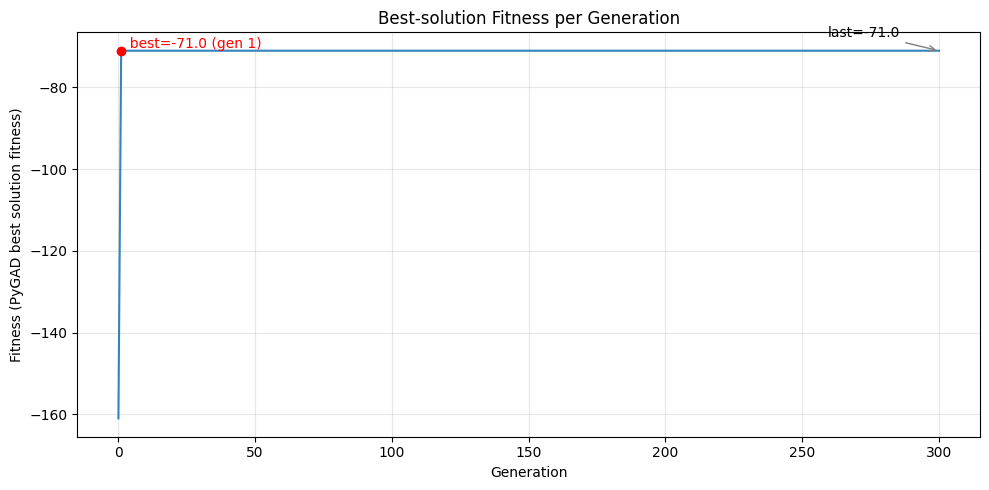

In [12]:
# Plot: best solution fitness per generation
# Requires `ga_instance` from the previous cell (run the GA cell first).
try:
    fitness_history = np.array(ga_instance.best_solutions_fitness)
except NameError:
    print("`ga_instance` not found. Run the GA cell (the one that calls `ga_instance.run()`) first.")
else:
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, lw=1.5, color='tab:blue', alpha=0.9)
    plt.title('Best-solution Fitness per Generation')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (PyGAD best solution fitness)')
    plt.grid(alpha=0.3)
    # Annotate best and last values
    best_idx = np.argmax(fitness_history)
    best_val = fitness_history[best_idx]
    last_val = fitness_history[-1]
    plt.scatter([best_idx], [best_val], color='red', zorder=5)
    plt.text(best_idx, best_val, f'  best={best_val:.1f} (gen {best_idx})', va='bottom', color='red')
    plt.annotate(f'last={last_val:.1f}', xy=(len(fitness_history)-1, last_val), xytext=(-80, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='gray'))
    plt.tight_layout()
    plt.show()

In [13]:
shortest = 0
graph_acc = nx.DiGraph()
# list of nodes to neighbour with weights
nnw = []

# build edge list (skip empty adjacency lists)
for i, adj in enumerate(graph_edges):
    if not adj:
        continue
    for (neighbour, weight) in adj:
        # use tuple (u, v, weight) for add_weighted_edges_from
        nnw.append((i, neighbour, weight))
graph_acc.add_weighted_edges_from(nnw)

#dijkstra_arr.append(nx.shortest_path_length(graph, source=start, target=goal, weight='weight'))

for i in range(len(checkpoints) - 1):
    first = checkpoints[i]
    second = checkpoints[i + 1]
    shortest += nx.shortest_path_length(graph_acc, source=first, target=second, weight='weight')
    print(nx.shortest_path(graph_acc, source=first, target=second, weight='weight'))


print("Shortest path in the graph :", shortest)

[1, 78, 2]
[2, 4, 56, 49, 3]
[3, 56, 5]
[5, 94, 98, 100]
Shortest path in the graph : 14


# Testing custom mutation 
#### Test it on 3 graphs - 10 nodes, 30 nodes and 50 nodes
#### Test it using 3 different mutation probabilities [0.4, 0.7, 1.0]

In [68]:
# Generate all possible configurations using itertools.product
import itertools

# Define parameter options -> we test mutation so we freeze all other parameters exept for mutation probability
# this is how we will see whhat is the impact of my custom mutation
custom_mutation_types = [custom_mutation]
builtin_mutation_types = ['adaptive']
custom_crossover_types = [custom_crossover_1]
builtin_crossover_types = ['single_point']
crossover_probabilities = [0.8]
mutation_probabilities = [0.2, 0.4, 0.6, 0.8, 1.0]
# Adaptive mutation requires [min, max] range instead of single value
# We'll test different ranges based on the single values above
adaptive_mutation_ranges = [
    [0.3, 0.1],   # Low range (around 0.2)
    [0.5, 0.3],   # Medium-low range (around 0.4)
    [0.7, 0.5],   # Medium range (around 0.6)
    [0.9, 0.7],   # Medium-high range (around 0.8)
    [1.0, 0.9]    # High range (around 1.0)
]
parent_selection_types = ['rank']


# Generate all combinations for testing custom mutation
all_configurations = []

# Custom crossover + Custom mutation (no probabilities needed)
for crossover, mutation, cp, mp, parent_sel in itertools.product(
    custom_crossover_types, custom_mutation_types, crossover_probabilities, mutation_probabilities, parent_selection_types
):
    config = {
        'crossover_type': crossover,
        'mutation_type': mutation,
        'crossover_probability': cp,
        'mutation_probability': mp,
        'parent_selection_type': parent_sel
    }
    all_configurations.append(config)


print(f"\n{'='*60}")
print(f"Total configurations to test for custom_mutation: {len(all_configurations)}")
print(f"Configurations for testing custom mutation with different parameters ready.")
print(all_configurations[0])
print(f"\n{'='*60}")

# Generate all combinations for testing adaptive mutation
all_configurations_1 = []

# Custom crossover + Adaptive mutation (requires [min, max] range)
for crossover, mutation, cp, mp_range, parent_sel in itertools.product(
    custom_crossover_types, builtin_mutation_types, crossover_probabilities, adaptive_mutation_ranges, parent_selection_types
):
    config = {
        'crossover_type': crossover,
        'mutation_type': mutation,
        'crossover_probability': cp,
        'mutation_probability': mp_range,  # This is now a [min, max] list
        'parent_selection_type': parent_sel
    }
    all_configurations_1.append(config)

print(f"\n{'='*60}")
print(f"Total configurations to test for adaptive mutation: {len(all_configurations_1)}")
print(f"Configurations for testing adaptive mutation with different parameters ready.")
print(all_configurations_1[0])
print(f"\n{'='*60}")



Total configurations to test for custom_mutation: 5
Configurations for testing custom mutation with different parameters ready.
{'crossover_type': <function custom_crossover_1 at 0x7f725b0d99e0>, 'mutation_type': <function custom_mutation at 0x7f725aefeac0>, 'crossover_probability': 0.8, 'mutation_probability': 0.2, 'parent_selection_type': 'rank'}


Total configurations to test for adaptive mutation: 5
Configurations for testing adaptive mutation with different parameters ready.
{'crossover_type': <function custom_crossover_1 at 0x7f725b0d99e0>, 'mutation_type': 'adaptive', 'crossover_probability': 0.8, 'mutation_probability': [0.3, 0.1], 'parent_selection_type': 'rank'}



In [67]:
# Main testing loop: Test all configurations on all graph variations
import time

# Graph parameters
node_counts = [10, 30, 50]  # Different graph sizes
edge_probabilities = [0.8, 1.0]  # Different densities
num_initial_populations = 3 # Number of different initial populations per graph

# Total number of graphs to test
total_graphs = len(node_counts) * len(edge_probabilities)
print(f"Testing {len(all_configurations)} configurations on {total_graphs} graphs")
print(f"Each graph tested with {num_initial_populations} different initial populations")
print(f"Total GA runs: {len(all_configurations) * total_graphs * num_initial_populations}")



# Store results: config_results[config_idx] = average best fitness over all runs
config_results = np.zeros(len(all_configurations))

# Store fitness curves: config_curves[config_idx] = average fitness per generation
config_curves = np.zeros((len(all_configurations), 1001))

# Store detailed results for analysis
config_details = []

# Track total Dijkstra distance across all graphs for computing average optimal
dijkstra_total = 0
graphs_processed = 0

start_time = time.time()



# Loop through all graph variations
graph_idx = 0
for num_nodes_test in node_counts:
    for p_test in edge_probabilities:
        graph_idx += 1
        print(f"\n{'='*60}")
        print(f"Graph {graph_idx}/{total_graphs}: n={num_nodes_test}, p={p_test}")
        print(f"{'='*60}")
        
        # Generate and save the graph
        start = 1
        goal = num_nodes_test
        edges = directed(num_nodes_test, p_test, seed=random.randint(0, 100000))
        # writes to directory graphs_test_task2
        write_graph_txt(start, goal, num_nodes_test, edges, 
                       f"task2_graph_test_n{num_nodes_test}_p{p_test}.txt")
        
        # Read the graph back
        num_nodes, start, goal, graph_edges = read_graph_from_txt(
            f'graphs/graph_test_n{num_nodes_test}_p{p_test}.txt'
        )



        # define checkpoints
        checkpoints_len = max(5, num_nodes_test // 3)
        
        # so that a certain graph always gets the same checkpoints
        # graph n=10, p= 0.8 always gets the same checkpoints -> makes results reproducible and comparable
        seed = num_nodes_test * 1000 + int(p_test * 100) # deterministic seed
        random.seed(seed)

        # sample (checkpoints_len - 2) random nodes that are not the start or the goal
        selected = random.sample(range(2, num_nodes_test), checkpoints_len-2)
        
        # my checkpoints
        checkpoints = [start] + selected + [goal]

        # reset the seed for initial population generation (it should be random)
        random.seed(None)

        # Calculate optimal (Dijkstra) path through all checkpoints in order
        graph_nx = nx.DiGraph()
        for i, adj in enumerate(graph_edges):
            if not adj:
                continue
            for (neighbour, weight) in adj:
                graph_nx.add_weighted_edges_from([(i, neighbour, weight)])
        
        try:
            # Calculate shortest path between consecutive checkpoints
            dijkstra_distance = 0
            for i in range(len(checkpoints) - 1):
                segment_distance = nx.shortest_path_length(
                    graph_nx, 
                    source=checkpoints[i], 
                    target=checkpoints[i + 1], 
                    weight='weight' # means to use the weight attribute
                )
                dijkstra_distance += segment_distance
            
            print(f"Optimal path length through checkpoints (Dijkstra): {dijkstra_distance}")
            print(f"  Checkpoints: {checkpoints}")
            
            # Accumulate for average calculation
            dijkstra_total += dijkstra_distance
            graphs_processed += 1
        except nx.NetworkXNoPath:
            print(f"WARNING: No path exists between checkpoints in this graph! Skipping...")
            continue


        # Test each configuration on this graph with multiple initial populations
        for init_pop_idx in range(num_initial_populations):
            # Generate initial population (same for all configs on this run)
            population_size = 100
            pop = initial_population_checkpoint_walk(population_size, num_nodes, checkpoints, graph_edges)
            
            # Test each configuration
            for config_idx, config in enumerate(all_configurations):
                # Progress indicator every 20 configs
                if config_idx % 5 == 0:
                    elapsed = time.time() - start_time
                    print(f"  Graph {graph_idx}/{total_graphs}, Pop {init_pop_idx+1}/{num_initial_populations}, "
                          f"Config {config_idx+1}/{len(all_configurations)} "
                          f"[Elapsed: {elapsed/60:.1f}min]")
                
                # Create GA instance with this configuration
                ga_params = {
                    'num_generations': 1000,
                    'num_parents_mating': 20,
                    'fitness_func': fitness_func,
                    'initial_population': pop,
                    'gene_type': int,
                    'parent_selection_type': config['parent_selection_type'],
                    'crossover_type': config['crossover_type'],
                    'crossover_probability': config['crossover_probability'],
                    'mutation_probability': config['mutation_probability'],
                    'mutation_type': config['mutation_type'],
                    'mutation_percent_genes': "default", # worse solutions get more than 10% of genes mutated, and better get less than 10% of genes mutated
                    'gene_space': np.arange(1, num_nodes + 1).tolist(),
                    'save_best_solutions': True
                }

                ga_instance = pygad.GA(**ga_params)

                # Run the GA
                ga_instance.run()

                # Get results
                solution, solution_fitness, solution_idx = ga_instance.best_solution()
                solution_fitness = -solution_fitness  # Convert back to positive cost

                # Accumulate results
                config_results[config_idx] += solution_fitness
                config_curves[config_idx] += ga_instance.best_solutions_fitness



# Average results over all runs
total_runs = graphs_processed * num_initial_populations
config_results /= total_runs
config_curves /= total_runs


# Calculate average optimal fitness across all graphs
avg_optimal_fitness = -(dijkstra_total / graphs_processed)  # Negative for fitness representation

print(f"\n{'='*60}")
print(f"Testing complete!")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"Average optimal fitness (Dijkstra): {avg_optimal_fitness:.2f}")
print(f"{'='*60}")

Testing 5 configurations on 6 graphs
Each graph tested with 3 different initial populations
Total GA runs: 90

Graph 1/6: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 182
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/6, Pop 1/3, Config 1/5 [Elapsed: 0.0min]
  Graph 1/6, Pop 2/3, Config 1/5 [Elapsed: 0.5min]
  Graph 1/6, Pop 3/3, Config 1/5 [Elapsed: 1.0min]

Graph 2/6: n=10, p=1.0
Optimal path length through checkpoints (Dijkstra): 140
  Checkpoints: [1, 6, 3, 5, 10]
  Graph 2/6, Pop 1/3, Config 1/5 [Elapsed: 1.5min]
  Graph 2/6, Pop 2/3, Config 1/5 [Elapsed: 2.1min]
  Graph 2/6, Pop 3/3, Config 1/5 [Elapsed: 2.7min]

Graph 3/6: n=30, p=0.8
Optimal path length through checkpoints (Dijkstra): 145
  Checkpoints: [1, 28, 16, 17, 3, 11, 10, 23, 13, 30]
  Graph 3/6, Pop 1/3, Config 1/5 [Elapsed: 3.3min]
  Graph 3/6, Pop 2/3, Config 1/5 [Elapsed: 4.8min]
  Graph 3/6, Pop 3/3, Config 1/5 [Elapsed: 6.3min]

Graph 4/6: n=30, p=1.0
Optimal path length through checkpoints (Dijkstra

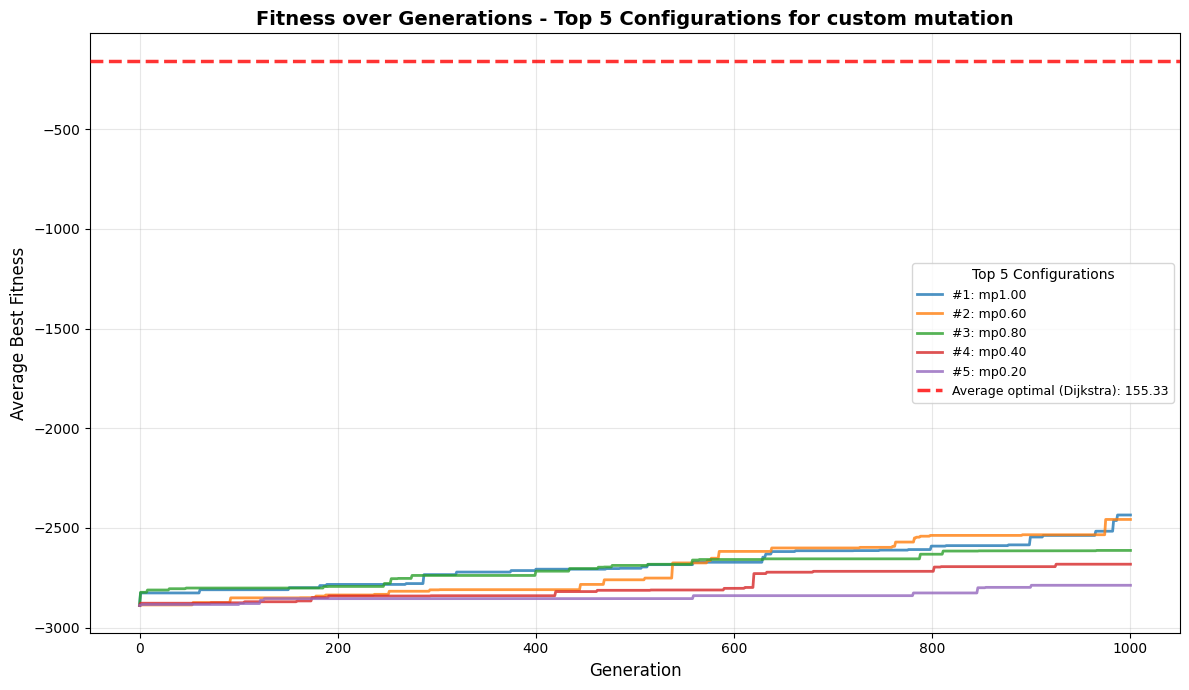

In [77]:
top_5_indices = np.argsort(config_results)[:5]

# Plot 1: Fitness over generations for TOP 5 configurations

plt.figure(figsize=(12, 7))
plt.title("Fitness over Generations - Top 5 Configurations for custom mutation", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Average Best Fitness", fontsize=12)

# Plot each of the top 5 configurations
for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations[idx]
    
    label = (f"#{rank}: mp{config['mutation_probability']:.2f}")
    
    plt.plot(config_curves[idx], alpha=0.8, linewidth=2, label=label)

# Add horizontal line for average optimal (Dijkstra) solution
plt.axhline(y=avg_optimal_fitness, color='red', linestyle='--', linewidth=2.5, 
            label=f'Average optimal (Dijkstra): {-avg_optimal_fitness:.2f}', alpha=0.8, zorder=10)

plt.legend(title='Top 5 Configurations', loc='best', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

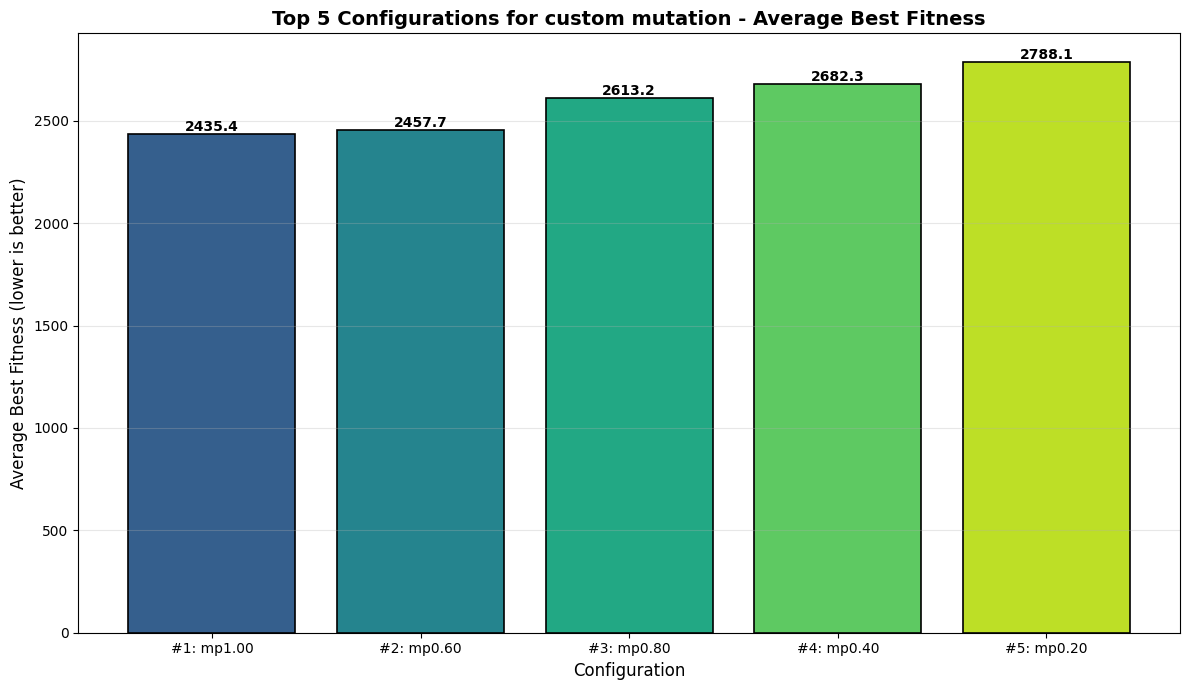


Summary Statistics:
  Best configuration fitness: 2435.39
  Worst (in top 5) fitness: 2788.06
  Fitness range: 352.67
  Average of top 5: 2595.33


In [ ]:
# Plot 2: Bar chart for 5 configurations

plt.figure(figsize=(12, 7))
plt.title("Top 5 Configurations for custom mutation - Average Best Fitness", fontsize=14, fontweight='bold')
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Average Best Fitness (lower is better)", fontsize=12)

# Prepare data for bar chart
top_5_fitness = [config_results[idx] for idx in top_5_indices]
top_5_labels = []

for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations[idx]
    
    label = f"#{rank}: mp{config['mutation_probability']:.2f}"
    
    top_5_labels.append(label)

# Create bar chart with color gradient (best = darkest)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 5))
bars = plt.bar(range(5), top_5_fitness, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for i, (bar, fitness) in enumerate(zip(bars, top_5_fitness)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{fitness:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(range(5), top_5_labels, fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"  Best configuration fitness: {top_5_fitness[0]:.2f}")
print(f"  Worst (in top 5) fitness: {top_5_fitness[-1]:.2f}")
print(f"  Fitness range: {top_5_fitness[-1] - top_5_fitness[0]:.2f}")
print(f"  Average of top 5: {np.mean(top_5_fitness):.2f}")



In [85]:
# Main testing loop: Test all configurations on all graph variations
import time

# Graph parameters
node_counts = [10, 30, 50]  # Different graph sizes
edge_probabilities = [0.8, 1.0]  # Different densities
num_initial_populations = 3 # Number of different initial populations per graph

# Total number of graphs to test
total_graphs = len(node_counts) * len(edge_probabilities)
print(f"Testing {len(all_configurations_1)} configurations on {total_graphs} graphs")
print(f"Each graph tested with {num_initial_populations} different initial populations")
print(f"Total GA runs: {len(all_configurations_1) * total_graphs * num_initial_populations}")



# Store results: config_results[config_idx] = average best fitness over all runs
config_results = np.zeros(len(all_configurations_1))

# Store fitness curves: config_curves[config_idx] = average fitness per generation
config_curves = np.zeros((len(all_configurations_1), 1001))

# Store detailed results for analysis
config_details = []

# Track total Dijkstra distance across all graphs for computing average optimal
dijkstra_total = 0
graphs_processed = 0

start_time = time.time()



# Loop through all graph variations
graph_idx = 0
for num_nodes_test in node_counts:
    for p_test in edge_probabilities:
        graph_idx += 1
        print(f"\n{'='*60}")
        print(f"Graph {graph_idx}/{total_graphs}: n={num_nodes_test}, p={p_test}")
        print(f"{'='*60}")
        
        # Generate and save the graph
        start = 1
        goal = num_nodes_test
        edges = directed(num_nodes_test, p_test, seed=random.randint(0, 100000))
        # writes to directory graphs_test_task2
        write_graph_txt(start, goal, num_nodes_test, edges, 
                       f"task2_graph_test_n{num_nodes_test}_p{p_test}.txt")
        
        # Read the graph back
        num_nodes, start, goal, graph_edges = read_graph_from_txt(
            f'graphs/graph_test_n{num_nodes_test}_p{p_test}.txt'
        )



        # define checkpoints
        checkpoints_len = max(5, num_nodes_test // 3)
        
        # so that a certain graph always gets the same checkpoints
        # graph n=10, p= 0.8 always gets the same checkpoints -> makes results reproducible and comparable
        seed = num_nodes_test * 1000 + int(p_test * 100) # deterministic seed
        random.seed(seed)

        # sample (checkpoints_len - 2) random nodes that are not the start or the goal
        selected = random.sample(range(2, num_nodes_test), checkpoints_len-2)
        
        # my checkpoints
        checkpoints = [start] + selected + [goal]

        # reset the seed for initial population generation (it should be random)
        random.seed(None)

        # Calculate optimal (Dijkstra) path through all checkpoints in order
        graph_nx = nx.DiGraph()
        for i, adj in enumerate(graph_edges):
            if not adj:
                continue
            for (neighbour, weight) in adj:
                graph_nx.add_weighted_edges_from([(i, neighbour, weight)])
        
        try:
            # Calculate shortest path between consecutive checkpoints
            dijkstra_distance = 0
            for i in range(len(checkpoints) - 1):
                segment_distance = nx.shortest_path_length(
                    graph_nx, 
                    source=checkpoints[i], 
                    target=checkpoints[i + 1], 
                    weight='weight' # means to use the weight attribute
                )
                dijkstra_distance += segment_distance
            
            print(f"Optimal path length through checkpoints (Dijkstra): {dijkstra_distance}")
            print(f"  Checkpoints: {checkpoints}")
            
            # Accumulate for average calculation
            dijkstra_total += dijkstra_distance
            graphs_processed += 1
        except nx.NetworkXNoPath:
            print(f"WARNING: No path exists between checkpoints in this graph! Skipping...")
            continue


        # Test each configuration on this graph with multiple initial populations
        for init_pop_idx in range(num_initial_populations):
            # Generate initial population (same for all configs on this run)
            population_size = 100
            pop = initial_population_checkpoint_walk(population_size, num_nodes, checkpoints, graph_edges)
            
            # Test each configuration
            for config_idx, config in enumerate(all_configurations_1):
                # Progress indicator every 20 configs
                if config_idx % 5 == 0:
                    elapsed = time.time() - start_time
                    print(f"  Graph {graph_idx}/{total_graphs}, Pop {init_pop_idx+1}/{num_initial_populations}, "
                          f"Config {config_idx+1}/{len(all_configurations_1)} "
                          f"[Elapsed: {elapsed/60:.1f}min]")
                
                # Create GA instance with this configuration
                ga_params = {
                    'num_generations': 1000,
                    'num_parents_mating': 20,
                    'fitness_func': fitness_func,
                    'initial_population': pop,
                    'gene_type': int,
                    'parent_selection_type': config['parent_selection_type'],
                    'crossover_type': config['crossover_type'],
                    'crossover_probability': config['crossover_probability'],
                    'mutation_probability': config['mutation_probability'],
                    'mutation_type': config['mutation_type'],
                    'mutation_percent_genes': "default", # worse solutions get more than 10% of genes mutated, and better get less than 10% of genes mutated
                    'gene_space': np.arange(1, num_nodes + 1).tolist(),
                    'save_best_solutions': True
                }

                ga_instance = pygad.GA(**ga_params)

                # Run the GA
                ga_instance.run()

                # Get results
                solution, solution_fitness, solution_idx = ga_instance.best_solution()
                solution_fitness = -solution_fitness  # Convert back to positive cost

                # Accumulate results
                config_results[config_idx] += solution_fitness
                config_curves[config_idx] += ga_instance.best_solutions_fitness



# Average results over all runs
total_runs = graphs_processed * num_initial_populations
config_results /= total_runs
config_curves /= total_runs


# Calculate average optimal fitness across all graphs
avg_optimal_fitness = -(dijkstra_total / graphs_processed)  # Negative for fitness representation

print(f"\n{'='*60}")
print(f"Testing complete!")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"Average optimal fitness (Dijkstra): {avg_optimal_fitness:.2f}")
print(f"{'='*60}")

Testing 5 configurations on 6 graphs
Each graph tested with 3 different initial populations
Total GA runs: 90

Graph 1/6: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 182
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/6, Pop 1/3, Config 1/5 [Elapsed: 0.0min]


/home/oskar/miniconda3/lib/python3.13/site-packages/pygad/pygad.py:1149: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


  Graph 1/6, Pop 2/3, Config 1/5 [Elapsed: 1.8min]
  Graph 1/6, Pop 3/3, Config 1/5 [Elapsed: 3.7min]
  Graph 1/6, Pop 3/3, Config 1/5 [Elapsed: 3.7min]

Graph 2/6: n=10, p=1.0
Optimal path length through checkpoints (Dijkstra): 140
  Checkpoints: [1, 6, 3, 5, 10]
  Graph 2/6, Pop 1/3, Config 1/5 [Elapsed: 5.5min]

Graph 2/6: n=10, p=1.0
Optimal path length through checkpoints (Dijkstra): 140
  Checkpoints: [1, 6, 3, 5, 10]
  Graph 2/6, Pop 1/3, Config 1/5 [Elapsed: 5.5min]
  Graph 2/6, Pop 2/3, Config 1/5 [Elapsed: 7.3min]
  Graph 2/6, Pop 2/3, Config 1/5 [Elapsed: 7.3min]
  Graph 2/6, Pop 3/3, Config 1/5 [Elapsed: 9.1min]
  Graph 2/6, Pop 3/3, Config 1/5 [Elapsed: 9.1min]

Graph 3/6: n=30, p=0.8
Optimal path length through checkpoints (Dijkstra): 145
  Checkpoints: [1, 28, 16, 17, 3, 11, 10, 23, 13, 30]
  Graph 3/6, Pop 1/3, Config 1/5 [Elapsed: 11.0min]

Graph 3/6: n=30, p=0.8
Optimal path length through checkpoints (Dijkstra): 145
  Checkpoints: [1, 28, 16, 17, 3, 11, 10, 23, 13, 3

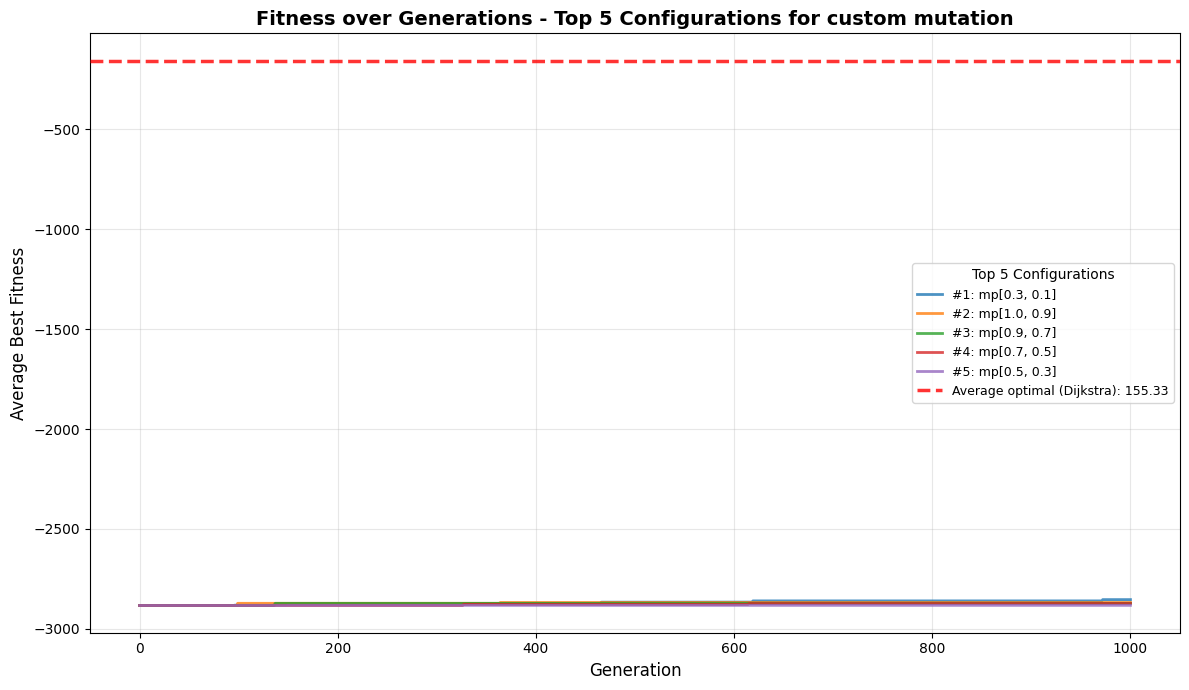

In [87]:
top_5_indices = np.argsort(config_results)[:5]

# Plot 1: Fitness over generations for TOP 5 configurations

plt.figure(figsize=(12, 7))
plt.title("Fitness over Generations - Top 5 Configurations for custom mutation", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Average Best Fitness", fontsize=12)

# Plot each of the top 5 configurations
for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations_1[idx]
    
    label = (f"#{rank}: mp{config['mutation_probability']}")
    
    plt.plot(config_curves[idx], alpha=0.8, linewidth=2, label=label)

# Add horizontal line for average optimal (Dijkstra) solution
plt.axhline(y=avg_optimal_fitness, color='red', linestyle='--', linewidth=2.5, 
            label=f'Average optimal (Dijkstra): {-avg_optimal_fitness:.2f}', alpha=0.8, zorder=10)

plt.legend(title='Top 5 Configurations', loc='best', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

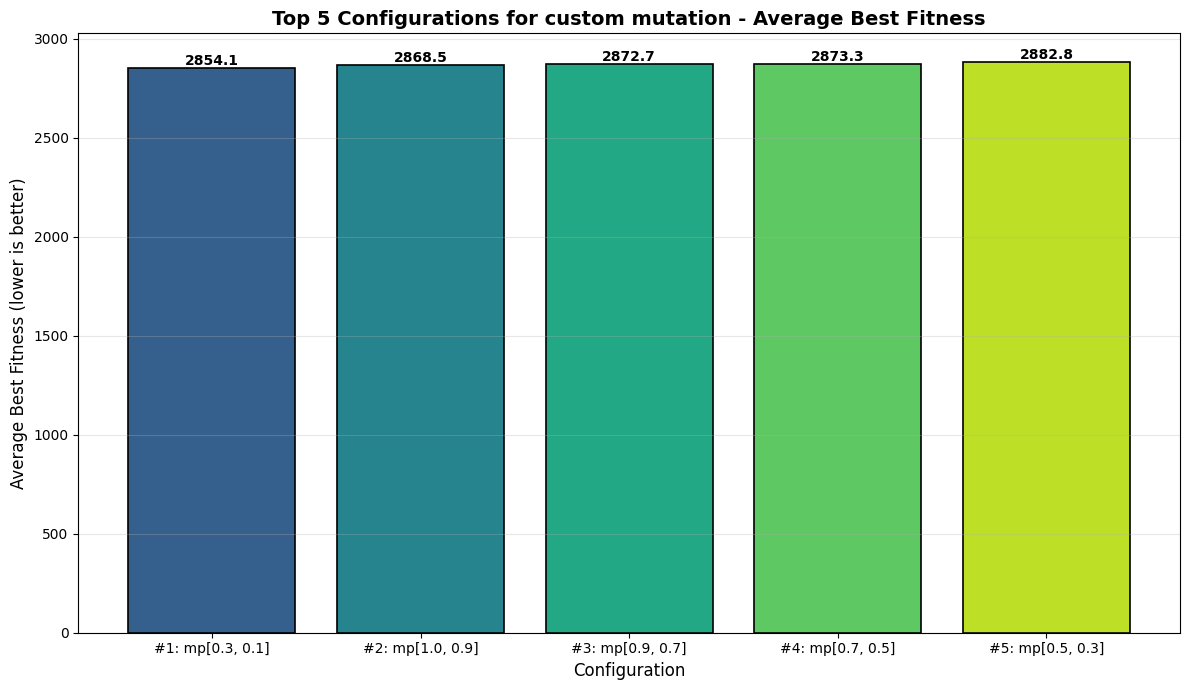


Summary Statistics:
  Best configuration fitness: 2854.11
  Worst (in top 5) fitness: 2882.83
  Fitness range: 28.72
  Average of top 5: 2870.29


In [89]:
# Plot 2: Bar chart for 5 configurations

plt.figure(figsize=(12, 7))
plt.title("Top 5 Configurations for custom mutation - Average Best Fitness", fontsize=14, fontweight='bold')
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Average Best Fitness (lower is better)", fontsize=12)

# Prepare data for bar chart
top_5_fitness = [config_results[idx] for idx in top_5_indices]
top_5_labels = []

for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations_1[idx]
    
    label = f"#{rank}: mp{config['mutation_probability']}"

    
    top_5_labels.append(label)

# Create bar chart with color gradient (best = darkest)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 5))
bars = plt.bar(range(5), top_5_fitness, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for i, (bar, fitness) in enumerate(zip(bars, top_5_fitness)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{fitness:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(range(5), top_5_labels, fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"  Best configuration fitness: {top_5_fitness[0]:.2f}")
print(f"  Worst (in top 5) fitness: {top_5_fitness[-1]:.2f}")
print(f"  Fitness range: {top_5_fitness[-1] - top_5_fitness[0]:.2f}")
print(f"  Average of top 5: {np.mean(top_5_fitness):.2f}")

In [132]:
import itertools
# Define parameter options -> we test mutation so we freeze all other parameters exept for mutation probability
# this is how we will see whhat is the impact of my custom mutation
custom_mutation_types = [custom_mutation]
custom_crossover_types = [custom_crossover_1]

crossover_probabilities = [0.6]
mutation_probabilities = [0.2, 0.4, 0.6, 0.8, 1.0]
parent_selection_types = ['tournament']


# Generate all combinations for testing custom mutation
all_configurations = []

# Custom crossover + Custom mutation (no probabilities needed)
for crossover, mutation, cp, mp, parent_sel in itertools.product(
    custom_crossover_types, custom_mutation_types, crossover_probabilities, mutation_probabilities, parent_selection_types
):
    config = {
        'crossover_type': crossover,
        'mutation_type': mutation,
        'crossover_probability': cp,
        'mutation_probability': mp,
        'parent_selection_type': parent_sel
    }
    all_configurations.append(config)


print(f"\n{'='*60}")
print(f"Total configurations to test for custom_mutation: {len(all_configurations)}")
print(f"Configurations for testing custom mutation with different parameters ready.")
print(all_configurations[0])
print(f"\n{'='*60}")


Total configurations to test for custom_mutation: 5
Configurations for testing custom mutation with different parameters ready.
{'crossover_type': <function custom_crossover_1 at 0x753ffb202ac0>, 'mutation_type': <function custom_mutation at 0x753ffb203240>, 'crossover_probability': 0.6, 'mutation_probability': 0.2, 'parent_selection_type': 'tournament'}



In [146]:
# Main testing loop: Test all configurations on all graph variations
import time

# Graph parameters
node_counts = [10, 20, 30]  # Different graph sizes
edge_probabilities = [0.8]  # Different densities
num_initial_populations = 4 # Number of different initial populations per graph

# Total number of graphs to test
total_graphs = len(node_counts) * len(edge_probabilities)
print(f"Testing {len(all_configurations)} configurations on {total_graphs} graphs")
print(f"Each graph tested with {num_initial_populations} different initial populations")
print(f"Total GA runs: {len(all_configurations) * total_graphs * num_initial_populations}")



# Store results: config_results[config_idx] = average best fitness over all runs
config_results = np.zeros(len(all_configurations))

# Store fitness curves: config_curves[config_idx] = average fitness per generation
config_curves = np.zeros((len(all_configurations), 101))

# Store detailed results for analysis
config_details = []

# Track total Dijkstra distance across all graphs for computing average optimal
dijkstra_total = 0
graphs_processed = 0

start_time = time.time()



# Loop through all graph variations
graph_idx = 0
for num_nodes_test in node_counts:
    for p_test in edge_probabilities:
        graph_idx += 1
        print(f"\n{'='*60}")
        print(f"Graph {graph_idx}/{total_graphs}: n={num_nodes_test}, p={p_test}")
        print(f"{'='*60}")
        
        # Generate and save the graph
        start = 1
        goal = num_nodes_test
        edges = directed(num_nodes_test, p_test, seed=random.randint(0, 100000))
        # writes to directory graphs_test_task2
        write_graph_txt(start, goal, num_nodes_test, edges, 
                       f"task2_graph_test_n{num_nodes_test}_p{p_test}.txt")
        
        # Read the graph back
        num_nodes, start, goal, graph_edges = read_graph_from_txt(
            f'graphs/task2_graph_test_n{num_nodes_test}_p{p_test}.txt'
        )



        # define checkpoints
        checkpoints_len = max(5, num_nodes_test // 3)
        
        # so that a certain graph always gets the same checkpoints
        # graph n=10, p= 0.8 always gets the same checkpoints -> makes results reproducible and comparable
        seed = num_nodes_test * 1000 + int(p_test * 100) # deterministic seed
        random.seed(seed)

        # sample (checkpoints_len - 2) random nodes that are not the start or the goal
        selected = random.sample(range(2, num_nodes_test), checkpoints_len-2)
        
        # my checkpoints
        checkpoints = [start] + selected + [goal]

        # reset the seed for initial population generation (it should be random)
        random.seed(None)

        # Calculate optimal (Dijkstra) path through all checkpoints in order
        graph_nx = nx.DiGraph()
        for i, adj in enumerate(graph_edges):
            if not adj:
                continue
            for (neighbour, weight) in adj:
                graph_nx.add_weighted_edges_from([(i, neighbour, weight)])
        
        try:
            # Calculate shortest path between consecutive checkpoints
            dijkstra_distance = 0
            for i in range(len(checkpoints) - 1):
                segment_distance = nx.shortest_path_length(
                    graph_nx, 
                    source=checkpoints[i], 
                    target=checkpoints[i + 1], 
                    weight='weight' # means to use the weight attribute
                )
                dijkstra_distance += segment_distance
            
            print(f"Optimal path length through checkpoints (Dijkstra): {dijkstra_distance}")
            print(f"  Checkpoints: {checkpoints}")
            
            # Accumulate for average calculation
            dijkstra_total += dijkstra_distance
            graphs_processed += 1
        except nx.NetworkXNoPath:
            print(f"WARNING: No path exists between checkpoints in this graph! Skipping...")
            continue


        # Test each configuration on this graph with multiple initial populations
        for init_pop_idx in range(num_initial_populations):
            # Generate initial population (same for all configs on this run)
            population_size = 30
            pop = initial_population_checkpoint_walk(population_size, num_nodes, checkpoints, graph_edges)
            
            # Test each configuration
            for config_idx, config in enumerate(all_configurations):
                # Progress indicator every 20 configs
                if config_idx % 5 == 0:
                    elapsed = time.time() - start_time
                    print(f"  Graph {graph_idx}/{total_graphs}, Pop {init_pop_idx+1}/{num_initial_populations}, "
                          f"Config {config_idx+1}/{len(all_configurations)} "
                          f"[Elapsed: {elapsed/60:.1f}min]")
                
                # Create GA instance with this configuration
                ga_params = {
                    'num_generations': 100,
                    'num_parents_mating': 10,
                    'fitness_func': fitness_func,
                    'initial_population': pop,
                    'gene_type': int,
                    'parent_selection_type': config['parent_selection_type'],
                    'crossover_type': config['crossover_type'],
                    'crossover_probability': config['crossover_probability'],
                    'mutation_probability': config['mutation_probability'],
                    'mutation_type': config['mutation_type'],
                    'mutation_percent_genes': "default", # worse solutions get more than 10% of genes mutated, and better get less than 10% of genes mutated
                    'gene_space': np.arange(1, num_nodes + 1).tolist(),
                    'save_best_solutions': True
                }

                ga_instance = pygad.GA(**ga_params)

                # Run the GA
                ga_instance.run()

                # Get results
                solution, solution_fitness, solution_idx = ga_instance.best_solution()
                solution_fitness = -solution_fitness  # Convert back to positive cost

                # Accumulate results
                config_results[config_idx] += solution_fitness
                config_curves[config_idx] += ga_instance.best_solutions_fitness



# Average results over all runs
total_runs = graphs_processed * num_initial_populations
config_results /= total_runs
config_curves /= total_runs


# Calculate average optimal fitness across all graphs
avg_optimal_fitness = -(dijkstra_total / graphs_processed)  # Negative for fitness representation

print(f"\n{'='*60}")
print(f"Testing complete!")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"Average optimal fitness (Dijkstra): {avg_optimal_fitness:.2f}")
print(f"{'='*60}")

Testing 5 configurations on 3 graphs
Each graph tested with 4 different initial populations
Total GA runs: 60

Graph 1/3: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 28
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/3, Pop 1/4, Config 1/5 [Elapsed: 0.0min]


Testing 5 configurations on 3 graphs
Each graph tested with 4 different initial populations
Total GA runs: 60

Graph 1/3: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 28
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/3, Pop 1/4, Config 1/5 [Elapsed: 0.0min]


/home/oskar/miniconda3/lib/python3.13/site-packages/pygad/pygad.py:1149: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Testing 5 configurations on 3 graphs
Each graph tested with 4 different initial populations
Total GA runs: 60

Graph 1/3: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 28
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/3, Pop 1/4, Config 1/5 [Elapsed: 0.0min]


/home/oskar/miniconda3/lib/python3.13/site-packages/pygad/pygad.py:1149: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


  Graph 1/3, Pop 2/4, Config 1/5 [Elapsed: 0.0min]
  Graph 1/3, Pop 3/4, Config 1/5 [Elapsed: 0.0min]
  Graph 1/3, Pop 3/4, Config 1/5 [Elapsed: 0.0min]
  Graph 1/3, Pop 4/4, Config 1/5 [Elapsed: 0.0min]
  Graph 1/3, Pop 4/4, Config 1/5 [Elapsed: 0.0min]

Graph 2/3: n=20, p=0.8
Optimal path length through checkpoints (Dijkstra): 39
  Checkpoints: [1, 19, 14, 18, 16, 20]
  Graph 2/3, Pop 1/4, Config 1/5 [Elapsed: 0.0min]

Graph 2/3: n=20, p=0.8
Optimal path length through checkpoints (Dijkstra): 39
  Checkpoints: [1, 19, 14, 18, 16, 20]
  Graph 2/3, Pop 1/4, Config 1/5 [Elapsed: 0.0min]
  Graph 2/3, Pop 2/4, Config 1/5 [Elapsed: 0.0min]
  Graph 2/3, Pop 2/4, Config 1/5 [Elapsed: 0.0min]
  Graph 2/3, Pop 3/4, Config 1/5 [Elapsed: 0.1min]
  Graph 2/3, Pop 3/4, Config 1/5 [Elapsed: 0.1min]
  Graph 2/3, Pop 4/4, Config 1/5 [Elapsed: 0.1min]
  Graph 2/3, Pop 4/4, Config 1/5 [Elapsed: 0.1min]

Graph 3/3: n=30, p=0.8
Optimal path length through checkpoints (Dijkstra): 58
  Checkpoints: [1, 28,

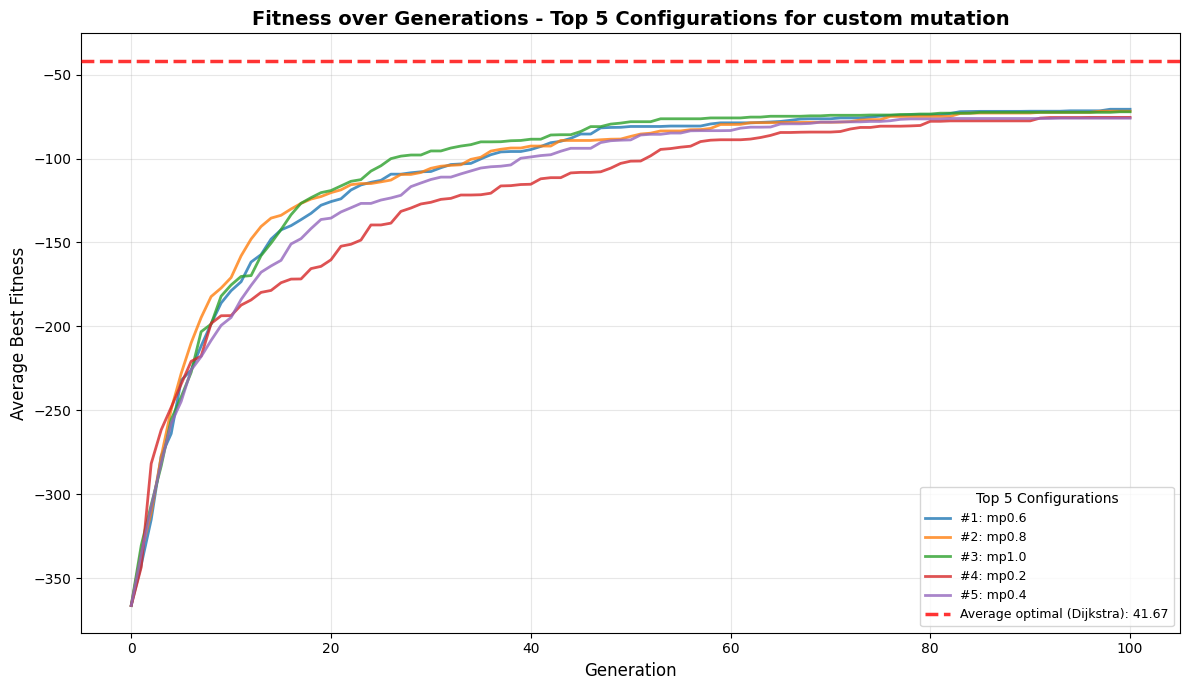

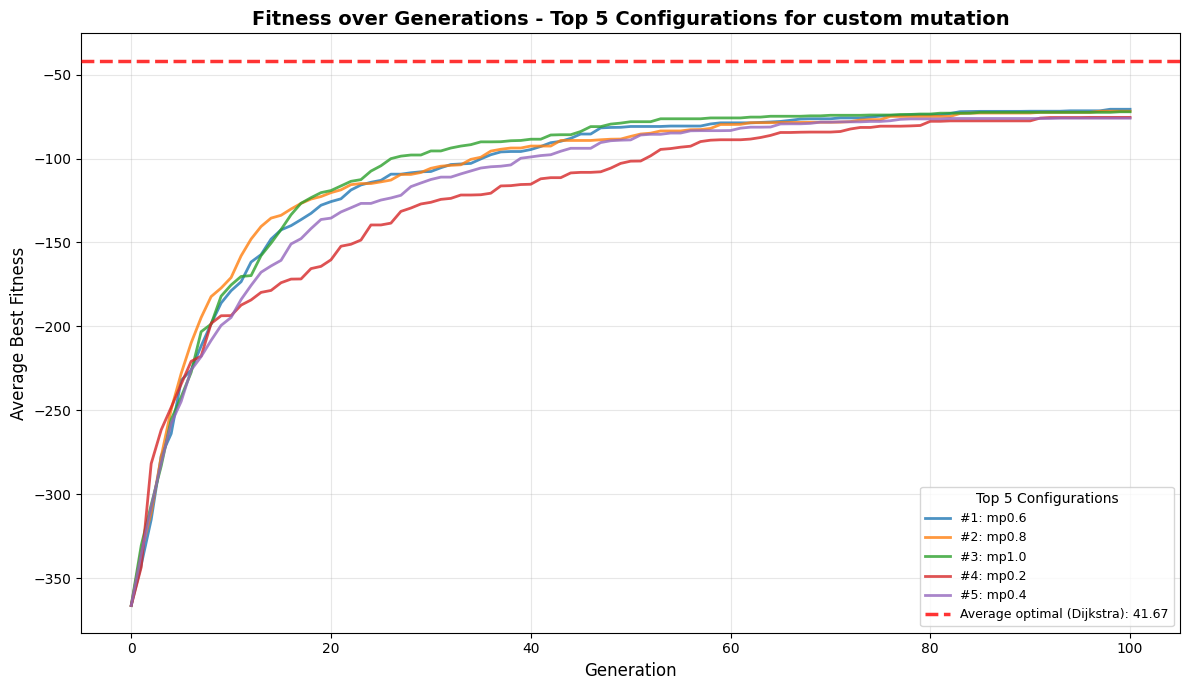

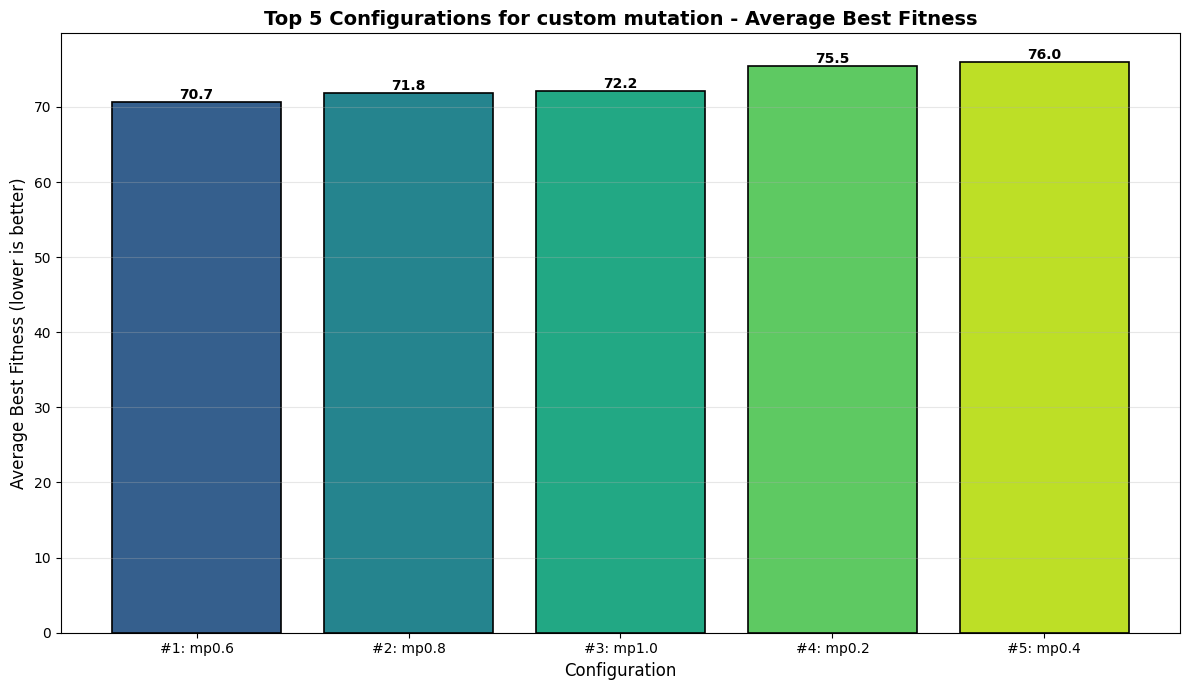

In [148]:
# graph
top_5_indices = np.argsort(config_results)[:5]

# Plot 1: Fitness over generations for TOP 5 configurations

plt.figure(figsize=(12, 7))
plt.title("Fitness over Generations - Top 5 Configurations for custom mutation", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Average Best Fitness", fontsize=12)

# Plot each of the top 5 configurations
for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations[idx]
    
    label = (f"#{rank}: mp{config['mutation_probability']}")
    
    plt.plot(config_curves[idx], alpha=0.8, linewidth=2, label=label)

# Add horizontal line for average optimal (Dijkstra) solution
plt.axhline(y=avg_optimal_fitness, color='red', linestyle='--', linewidth=2.5, 
            label=f'Average optimal (Dijkstra): {-avg_optimal_fitness:.2f}', alpha=0.8, zorder=10)

plt.legend(title='Top 5 Configurations', loc='best', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# bar chart
plt.figure(figsize=(12, 7))
plt.title("Top 5 Configurations for custom mutation - Average Best Fitness", fontsize=14, fontweight='bold')
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Average Best Fitness (lower is better)", fontsize=12)

# Prepare data for bar chart


top_5_fitness = [config_results[idx] for idx in top_5_indices]
top_5_labels = []

for rank, idx in enumerate(top_5_indices, 1):
    config = all_configurations[idx]
    
    label = f"#{rank}: mp{config['mutation_probability']}"

    
    top_5_labels.append(label)

# Create bar chart with color gradient (best = darkest)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 5))
bars = plt.bar(range(5), top_5_fitness, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for i, (bar, fitness) in enumerate(zip(bars, top_5_fitness)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{fitness:.1f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(range(5), top_5_labels, fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [149]:
## now test the optimal cofiguration mutiple times

import itertools
# Define parameter options -> we test mutation so we freeze all other parameters exept for mutation probability
# this is how we will see whhat is the impact of my custom mutation
custom_mutation_types = [custom_mutation]
custom_crossover_types = [custom_crossover_1]

crossover_probabilities = [0.6]
mutation_probabilities = [0.6]
parent_selection_types = ['tournament']


# Generate all combinations for testing custom mutation
all_configurations = []

# Custom crossover + Custom mutation (no probabilities needed)
for crossover, mutation, cp, mp, parent_sel in itertools.product(
    custom_crossover_types, custom_mutation_types, crossover_probabilities, mutation_probabilities, parent_selection_types
):
    config = {
        'crossover_type': crossover,
        'mutation_type': mutation,
        'crossover_probability': cp,
        'mutation_probability': mp,
        'parent_selection_type': parent_sel
    }
    all_configurations.append(config)


print(f"\n{'='*60}")
print(f"Total configurations to test for custom_mutation: {len(all_configurations)}")
print(f"Configurations for testing custom mutation with different parameters ready.")
print(all_configurations[0])
print(f"\n{'='*60}")


Total configurations to test for custom_mutation: 1
Configurations for testing custom mutation with different parameters ready.
{'crossover_type': <function custom_crossover_1 at 0x753ff4aa6160>, 'mutation_type': <function custom_mutation at 0x753ffb203060>, 'crossover_probability': 0.6, 'mutation_probability': 0.6, 'parent_selection_type': 'tournament'}



In [163]:
# Main testing loop: Test all configurations on all graph variations
import time

# Graph parameters
node_counts = [10, 30, 50]  # Different graph sizes
edge_probabilities = [0.8]  # Different densities
num_initial_populations = 30 # Number of different initial populations per graph

# Total number of graphs to test
total_graphs = len(node_counts) * len(edge_probabilities)
print(f"Testing {len(all_configurations)} configurations on {total_graphs} graphs")
print(f"Each graph tested with {num_initial_populations} different initial populations")
print(f"Total GA runs: {len(all_configurations) * total_graphs * num_initial_populations}")



# Store results: config_results[config_idx] = average best fitness over all runs
config_results = np.zeros(len(all_configurations))

# Store fitness curves: config_curves[config_idx] = average fitness per generation
config_curves = np.zeros((len(all_configurations), 101))

# Store detailed results for analysis
config_details = []

# Track total Dijkstra distance across all graphs for computing average optimal
dijkstra_total = 0
graphs_processed = 0

start_time = time.time()

num_optimal_solutions = 0

# Loop through all graph variations
graph_idx = 0
for num_nodes_test in node_counts:
    for p_test in edge_probabilities:
        graph_idx += 1
        print(f"\n{'='*60}")
        print(f"Graph {graph_idx}/{total_graphs}: n={num_nodes_test}, p={p_test}")
        print(f"{'='*60}")
        
        # Generate and save the graph
        start = 1
        goal = num_nodes_test
        edges = directed(num_nodes_test, p_test, seed=random.randint(0, 100000))
        # writes to directory graphs_test_task2
        write_graph_txt(start, goal, num_nodes_test, edges, 
                       f"task2_graph_test_n{num_nodes_test}_p{p_test}.txt")
        
        # Read the graph back
        num_nodes, start, goal, graph_edges = read_graph_from_txt(
            f'graphs/task2_graph_test_n{num_nodes_test}_p{p_test}.txt'
        )



        # define checkpoints
        checkpoints_len = max(5, num_nodes_test // 3)
        
        # so that a certain graph always gets the same checkpoints
        # graph n=10, p= 0.8 always gets the same checkpoints -> makes results reproducible and comparable
        seed = num_nodes_test * 1000 + int(p_test * 100) # deterministic seed
        random.seed(seed)

        # sample (checkpoints_len - 2) random nodes that are not the start or the goal
        selected = random.sample(range(2, num_nodes_test), checkpoints_len-2)
        
        # my checkpoints
        checkpoints = [start] + selected + [goal]

        # reset the seed for initial population generation (it should be random)
        random.seed(None)

        # Calculate optimal (Dijkstra) path through all checkpoints in order
        graph_nx = nx.DiGraph()
        for i, adj in enumerate(graph_edges):
            if not adj:
                continue
            for (neighbour, weight) in adj:
                graph_nx.add_weighted_edges_from([(i, neighbour, weight)])
        
        try:
            # Calculate shortest path between consecutive checkpoints
            dijkstra_distance = 0
            for i in range(len(checkpoints) - 1):
                segment_distance = nx.shortest_path_length(
                    graph_nx, 
                    source=checkpoints[i], 
                    target=checkpoints[i + 1], 
                    weight='weight' # means to use the weight attribute
                )
                dijkstra_distance += segment_distance
            
            print(f"Optimal path length through checkpoints (Dijkstra): {dijkstra_distance}")
            print(f"  Checkpoints: {checkpoints}")
            
            # Accumulate for average calculation
            dijkstra_total += dijkstra_distance
            graphs_processed += 1
        except nx.NetworkXNoPath:
            print(f"WARNING: No path exists between checkpoints in this graph! Skipping...")
            continue


        # Test each configuration on this graph with multiple initial populations
        for init_pop_idx in range(num_initial_populations):
            # Generate initial population (same for all configs on this run)
            population_size = 2*num_nodes_test
            pop = initial_population_checkpoint_walk(population_size, num_nodes, checkpoints, graph_edges)
            
            # Test each configuration
            for config_idx, config in enumerate(all_configurations):
                # Progress indicator every 20 configs
                if config_idx % 5 == 0:
                    elapsed = time.time() - start_time
                    print(f"  Graph {graph_idx}/{total_graphs}, Pop {init_pop_idx+1}/{num_initial_populations}, "
                          f"Config {config_idx+1}/{len(all_configurations)} "
                          f"[Elapsed: {elapsed/60:.1f}min]")
                
                # Create GA instance with this configuration
                ga_params = {
                    'num_generations': 100,
                    'num_parents_mating': num_nodes_test,
                    'fitness_func': fitness_func,
                    'initial_population': pop,
                    'gene_type': int,
                    'parent_selection_type': config['parent_selection_type'],
                    'crossover_type': config['crossover_type'],
                    'crossover_probability': config['crossover_probability'],
                    'mutation_probability': config['mutation_probability'],
                    'mutation_type': config['mutation_type'],
                    'mutation_percent_genes': "default", # worse solutions get more than 10% of genes mutated, and better get less than 10% of genes mutated
                    'gene_space': np.arange(1, num_nodes + 1).tolist(),
                    'save_best_solutions': True
                }

                ga_instance = pygad.GA(**ga_params)

                # Run the GA
                ga_instance.run()

                # Get results
                solution, solution_fitness, solution_idx = ga_instance.best_solution()
                solution_fitness = -solution_fitness  # Convert back to positive cost

                if(solution_fitness == dijkstra_total):
                    num_optimal_solutions += 1
                # Accumulate results
                config_results[config_idx] += solution_fitness
                config_curves[config_idx] += ga_instance.best_solutions_fitness



# Average results over all runs
total_runs = graphs_processed * num_initial_populations
config_results /= total_runs
config_curves /= total_runs


# Calculate average optimal fitness across all graphs
avg_optimal_fitness = -(dijkstra_total / graphs_processed)  # Negative for fitness representation

print(f"\n{'='*60}")
print(f"Testing complete!")
print(f"Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"Average optimal fitness (Dijkstra): {avg_optimal_fitness:.2f}")
print()

print("Number of optimal solutions = ", num_optimal_solutions)
print(f"{'='*60}")


Testing 1 configurations on 3 graphs
Each graph tested with 30 different initial populations
Total GA runs: 90

Graph 1/3: n=10, p=0.8
Optimal path length through checkpoints (Dijkstra): 32
  Checkpoints: [1, 2, 5, 3, 10]
  Graph 1/3, Pop 1/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 2/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 3/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 4/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 5/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 6/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 7/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 8/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 9/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 10/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 11/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 12/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 13/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 14/30, Config 1/1 [Elapsed: 0.0min]
  Graph 1/3, Pop 15/30, Config 1/1 [Elapsed: 

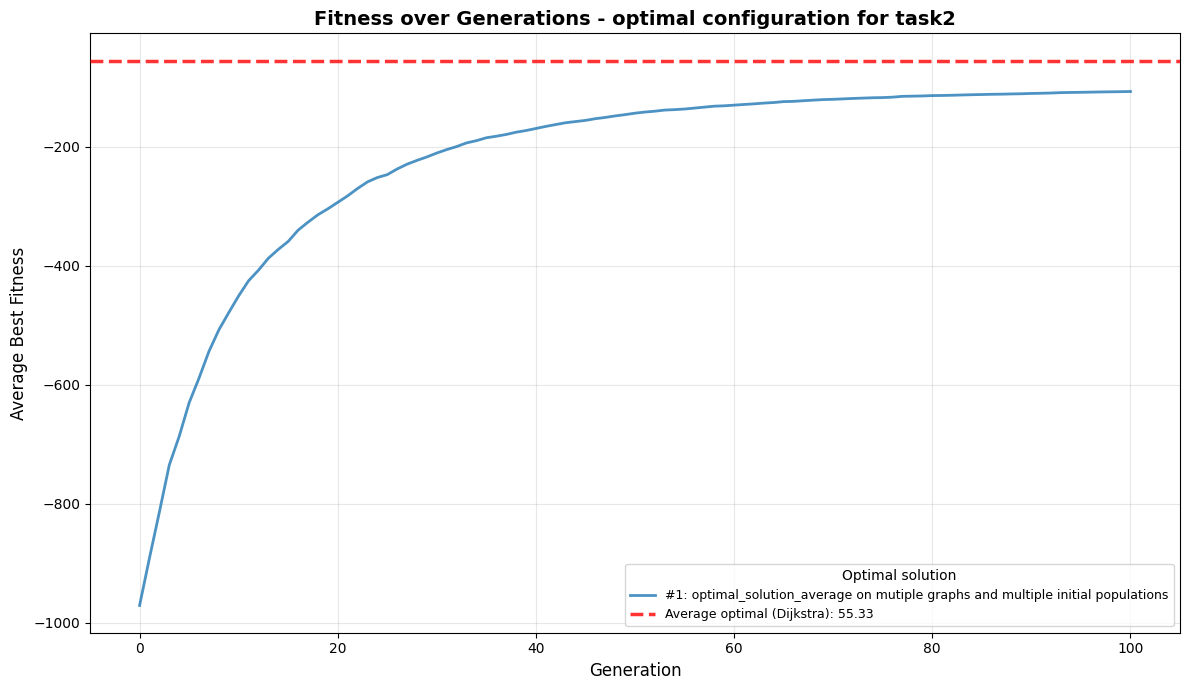

Number of optimal solutions =  6


In [ ]:
# graph

plt.figure(figsize=(12, 7))
plt.title("Fitness over Generations - optimal configuration for task2", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Average Best Fitness", fontsize=12)

# Plot each of the top 5 configurations

    
label = (f"#{rank}: optimal_solution_average on mutiple graphs and multiple initial populations")
    
plt.plot(config_curves[0], alpha=0.8, linewidth=2, label=label)

# Add horizontal line for average optimal (Dijkstra) solution
plt.axhline(y=avg_optimal_fitness, color='red', linestyle='--', linewidth=2.5, 
            label=f'Average optimal (Dijkstra): {-avg_optimal_fitness:.2f}', alpha=0.8, zorder=10)

plt.legend(title='Optimal solution average on mutiple graphs and multiple initial populations', loc='best', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print("Number of optimal solutions = ", num_optimal_solutions)

(np.float64(-0.5), np.float64(1188.5), np.float64(689.5), np.float64(-0.5))

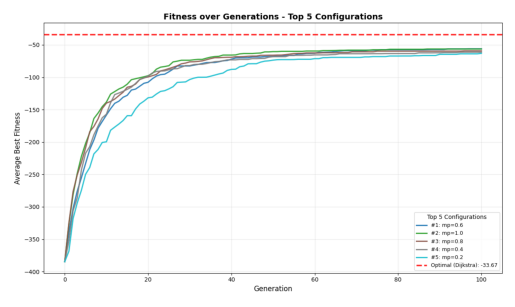

In [160]:
import matplotlib.pyplot as plt

I = plt.imread("optimal_parameters_search/mp_search/optimal_mutation_probability_for_custom_mutation_graph.png")

plt.imshow(I)
plt.axis('off')